Successfully connected to node at localhost:5000
ACL applied to node 2, new vulnerability level: 0.31
Firewall applied to node 5, new vulnerability level: 0.26
ACL applied to node 6, new vulnerability level: 0.56
Encryption applied to node 8, new vulnerability level: 0.33
ACL applied to node 9, new vulnerability level: 0.49
Firewall applied to node 1, new vulnerability level: 0.46
Encryption applied to node 3, new vulnerability level: 0.37
ACL applied to node 5, new vulnerability level: 0.32
Encryption applied to node 8, new vulnerability level: 0.35
ACL applied to node 2, new vulnerability level: 0.35
Firewall applied to node 4, new vulnerability level: 0.37
Firewall applied to node 6, new vulnerability level: 0.42
Encryption applied to node 9, new vulnerability level: 0.37
ACL applied to node 1, new vulnerability level: 0.52
Firewall applied to node 2, new vulnerability level: 0.46
Encryption applied to node 4, new vulnerability level: 0.31
Encryption applied to node 6, new vulnerabi

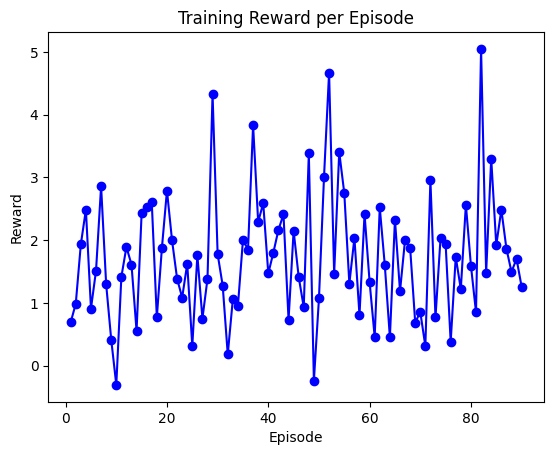

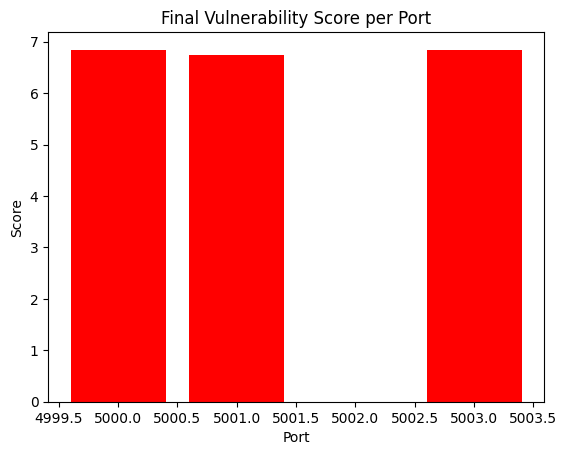

In [1]:
import tkinter as tk
from tkinter import ttk
import requests
import telnetlib
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Define the penetration testing environment
class PenTestEnv:
    def __init__(self, host, port):
        self.state_space = 10  # Example: 10 different nodes
        self.action_space = ['ping', 'nmap_scan', 'vuln_scan', 'apply_firewall', 'apply_acl', 'apply_encryption']
        self.host = host
        self.port = port
        self.current_state = 0
        # Initial vulnerability levels, higher values mean more vulnerable
        self.vulnerability_levels = np.random.uniform(0.5, 1, self.state_space)  # Start with higher vulnerabilities
        self.security_measures = np.zeros(self.state_space)  # Track applied security measures (0 = none, 1 = secure)

    def reset(self):
        self.current_state = 0
        self.vulnerability_levels = np.random.uniform(0.5, 1, self.state_space)  # Reset vulnerabilities
        self.security_measures = np.zeros(self.state_space)  # Reset security measures
        return self.current_state

    def check_node_exists(self):
        # Try to establish a Telnet connection to the node to check if it exists
        try:
            with telnetlib.Telnet(self.host, self.port, timeout=5) as tn:
                print(f"Successfully connected to node at {self.host}:{self.port}")
                return True
        except Exception as e:
            print(f"Failed to connect to node at {self.host}:{self.port}: {str(e)}")
            return False
    
    def step(self, action):
        reward = 0
        
        if action == 'ping':
            reward = self.ping_action()
        elif action == 'nmap_scan':
            reward = self.nmap_scan_action()
        elif action == 'vuln_scan':
            reward = self.vuln_scan_action()
        elif action == 'apply_firewall':
            reward = self.apply_firewall_action()
        elif action == 'apply_acl':
            reward = self.apply_acl_action()
        elif action == 'apply_encryption':
            reward = self.apply_encryption_action()

        # Increment the state but ensure it stays within bounds
        self.current_state += 1
        done = self.current_state >= self.state_space

        # If done, reset current_state to prevent out-of-bounds issues
        if done:
            self.current_state = self.state_space - 1
        
        return self.current_state, reward, done
    
    def ping_action(self):
        # Simulate a ping action
        if self.security_measures[self.current_state] == 0:  # More vulnerable without security measures
            reward = self.vulnerability_levels[self.current_state] * 0.1  # Lower reward for a successful ping
        else:
            reward = 0.05  # Lower impact on security
        return reward
    
    def nmap_scan_action(self):
        # Simulate an nmap scan action
        if self.security_measures[self.current_state] == 0:
            reward = self.vulnerability_levels[self.current_state] * 0.5  # Medium reward for detecting open ports
        else:
            reward = 0.1  # Reduced reward for scanning on a secured node
        return reward
    
    def vuln_scan_action(self):
        # Simulate a vulnerability scan action
        if self.security_measures[self.current_state] == 0:
            reward = self.vulnerability_levels[self.current_state]  # High reward for detecting vulnerabilities
        else:
            reward = 0.2  # Reduced reward after security measures are applied
        return reward

    def apply_firewall_action(self):
        # Simulate applying a firewall, which reduces vulnerability
        self.security_measures[self.current_state] = 1
        self.vulnerability_levels[self.current_state] *= 0.5  # Reduce vulnerability by half
        reward = -0.1  # Slight negative reward for applying security (cost)
        print(f"Firewall applied to node {self.current_state}, new vulnerability level: {self.vulnerability_levels[self.current_state]:.2f}")
        return reward
    
    def apply_acl_action(self):
        # Simulate applying an ACL, which reduces vulnerability
        self.security_measures[self.current_state] = 1
        self.vulnerability_levels[self.current_state] *= 0.6  # Reduce vulnerability by 40%
        reward = -0.1  # Slight negative reward for applying security (cost)
        print(f"ACL applied to node {self.current_state}, new vulnerability level: {self.vulnerability_levels[self.current_state]:.2f}")
        return reward
    
    def apply_encryption_action(self):
        # Simulate applying encryption, which reduces vulnerability
        self.security_measures[self.current_state] = 1
        self.vulnerability_levels[self.current_state] *= 0.4  # Reduce vulnerability by 60%
        reward = -0.2  # Slight negative reward for applying security (cost)
        print(f"Encryption applied to node {self.current_state}, new vulnerability level: {self.vulnerability_levels[self.current_state]:.2f}")
        return reward

# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995):
        self.env = env
        self.q_table = np.zeros((env.state_space, len(env.action_space)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
    
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(len(self.env.action_space)))  # Explore
        return np.argmax(self.q_table[state])  # Exploit
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        self.q_table[state, action] += self.learning_rate * (td_target - self.q_table[state, action])
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def test_agent(self):
        # Set epsilon to 0 for exploitation (no exploration)
        self.epsilon = 0
        state = self.env.reset()
        done = False
        total_vulnerability_score = 0
        
        while not done:
            # Always choose the best action based on the learned Q-table
            action_idx = np.argmax(self.q_table[state])
            action = self.env.action_space[action_idx]
            
            # Take action and observe the result
            next_state, reward, done = self.env.step(action)
            
            # Accumulate the vulnerability score (total reward)
            total_vulnerability_score += reward
            
            # Move to the next state
            state = next_state
        
        return total_vulnerability_score

# GUI Implementation
class App:
    def __init__(self, root):
        self.root = root
        self.root.title("Penetration Testing RL Application")

        self.gns3_server_url = "http://localhost:3080/v2"
        
        # Dropdown for selecting project
        self.project_label = ttk.Label(root, text="Select Project:")
        self.project_label.pack(pady=10)

        self.project_var = tk.StringVar()
        self.project_dropdown = ttk.Combobox(root, textvariable=self.project_var)
        self.project_dropdown.pack(pady=10)

        # Start Button
        self.start_button = ttk.Button(root, text="Start", command=self.run_pen_test)
        self.start_button.pack(pady=10)
        
        # Label to display final score
        self.result_label = ttk.Label(root, text="")
        self.result_label.pack(pady=10)

        # Frame to hold the graphs side by side
        self.graph_frame = tk.Frame(root)
        self.graph_frame.pack(pady=10)

        # Setup the matplotlib figures and canvases for the graphs
        self.fig_reward, self.ax_reward = plt.subplots()
        self.fig_vulnerability, self.ax_vulnerability = plt.subplots()

        # Canvas for training rewards graph (left side)
        self.canvas_reward = FigureCanvasTkAgg(self.fig_reward, self.graph_frame)
        self.canvas_reward.get_tk_widget().pack(side=tk.LEFT, padx=10)

        # Canvas for final vulnerability score graph (right side)
        self.canvas_vulnerability = FigureCanvasTkAgg(self.fig_vulnerability, self.graph_frame)
        self.canvas_vulnerability.get_tk_widget().pack(side=tk.LEFT, padx=10)

        # Fetch projects dynamically
        self.fetch_projects()

    def fetch_projects(self):
        try:
            # Fetch available projects
            response = requests.get(f"{self.gns3_server_url}/projects")
            if response.status_code == 200:
                projects = response.json()
                project_names = [project['name'] for project in projects]
                self.project_dropdown['values'] = project_names

                # Auto-select the first project
                if project_names:
                    self.project_dropdown.current(0)

        except Exception as e:
            print(f"Error fetching projects: {str(e)}")

    def run_pen_test(self):
        # Get the selected project
        selected_project = self.project_var.get()
        
        # Fetch ports for the selected project
        try:
            response = requests.get(f"{self.gns3_server_url}/projects")
            if response.status_code == 200:
                projects = response.json()
                for project in projects:
                    if project['name'] == selected_project:
                        project_id = project['project_id']
                        break

                # Fetch the available nodes (and their Telnet ports) for the selected project
                response = requests.get(f"{self.gns3_server_url}/projects/{project_id}/nodes")
                if response.status_code == 200:
                    nodes = response.json()
                    ports = [node['console'] for node in nodes if node['console']]

                    if ports:
                        self.test_ports(ports)

        except Exception as e:
            print(f"Error fetching ports: {str(e)}")

    def test_ports(self, ports):
        # Define the host
        host = "localhost"  # Adjust this to the correct IP
        
        episode_rewards = []
        port_scores = []

        for port in ports:
            # Initialize the environment and check node existence
            env = PenTestEnv(host, port)
            
            if env.check_node_exists():
                agent = QLearningAgent(env)
                episodes = 30

                # Training the RL agent
                for episode in range(episodes):
                    state = env.reset()
                    done = False
                    total_reward = 0

                    while not done:
                        action_idx = agent.choose_action(state)
                        action = env.action_space[action_idx]
                        next_state, reward, done = env.step(action)
                        agent.update_q_table(state, action_idx, reward, next_state)
                        state = next_state
                        total_reward += reward

                    episode_rewards.append(total_reward)
                    agent.decay_epsilon()

                # Test the agent and get the final vulnerability score for the port
                final_score = agent.test_agent()
                port_scores.append((port, final_score))

        # Calculate the final vulnerability score for the entire network
        if port_scores:
            network_final_score = np.mean([score for _, score in port_scores])
        else:
            network_final_score = 0

        # Update GUI with results
        self.result_label.config(text=f"Penetration Testing Completed. Final Network Score: {network_final_score:.2f}")

        # Plot the training rewards
        self.ax_reward.clear()
        self.ax_reward.plot(range(1, len(episode_rewards)+1), episode_rewards, marker='o', color='b')
        self.ax_reward.set_title('Training Reward per Episode')
        self.ax_reward.set_xlabel('Episode')
        self.ax_reward.set_ylabel('Reward')
        self.canvas_reward.draw()

        # Plot the final vulnerability scores for each port as a bar graph
        self.ax_vulnerability.clear()
        ports, scores = zip(*port_scores)
        self.ax_vulnerability.bar(ports, scores, color='r')
        self.ax_vulnerability.set_title('Final Vulnerability Score per Port')
        self.ax_vulnerability.set_xlabel('Port')
        self.ax_vulnerability.set_ylabel('Score')
        self.canvas_vulnerability.draw()

# Run the GUI
root = tk.Tk()
app = App(root)
root.mainloop()
